# imports

In [1]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
from sklearn.ensemble import RandomForestRegressor

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# load data

In [3]:
df7 = pd.read_csv('data/df6.csv',low_memory=False)

In [4]:
df7.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,...,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos,sales,date
0,1,1,2,1,-0.170968,9,2008,0,31,2015,...,-0.5,-0.866025,-2.449294e-16,1.0,-0.568065,-0.822984,-0.974928,-0.222521,8.568456,2015-07-31
1,2,1,0,1,-0.283871,11,2007,1,13,2010,...,-0.5,-0.866025,-2.449294e-16,1.0,-0.568065,-0.822984,-0.974928,-0.222521,8.710125,2015-07-31
2,3,1,0,1,1.903226,12,2006,1,14,2011,...,-0.5,-0.866025,-2.449294e-16,1.0,-0.568065,-0.822984,-0.974928,-0.222521,9.025696,2015-07-31
3,4,1,2,3,-0.275806,9,2009,0,31,2015,...,-0.5,-0.866025,-2.449294e-16,1.0,-0.568065,-0.822984,-0.974928,-0.222521,9.546455,2015-07-31
4,5,1,0,1,4.448387,4,2015,0,31,2015,...,-0.5,-0.866025,-2.449294e-16,1.0,-0.568065,-0.822984,-0.974928,-0.222521,8.480944,2015-07-31


In [5]:
df7.shape

(844338, 23)

In [6]:
df7.dtypes

store                             int64
promo                             int64
store_type                        int64
assortment                        int64
competition_distance            float64
competition_open_since_month      int64
competition_open_since_year       int64
promo2                            int64
promo2_since_week                 int64
promo2_since_year                 int64
competition_time_month            int64
promo_time_week                 float64
competition_ time_month         float64
month_sin                       float64
month_cos                       float64
day_sin                         float64
day_cos                         float64
week_of_year_sin                float64
week_of_year_cos                float64
day_of_week_sin                 float64
day_of_week_cos                 float64
sales                           float64
date                             object
dtype: object

In [7]:
df7['date'] = pd.to_datetime(df7['date'])

# Split dataset

In [8]:
#train
x_train = df7[df7['date'] < '2015-06-19']
y_train = x_train['sales']

# test
x_test = df7[df7['date'] >= '2015-06-19']
y_test = x_test['sales']


cols_drop = ['date','sales']
x_train.drop(columns=cols_drop,axis=1,inplace=True)
x_test.drop(columns=cols_drop,axis=1,inplace=True)

C:\Users\Lavin\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Machine learning model

## Average Model

C:\Users\Lavin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

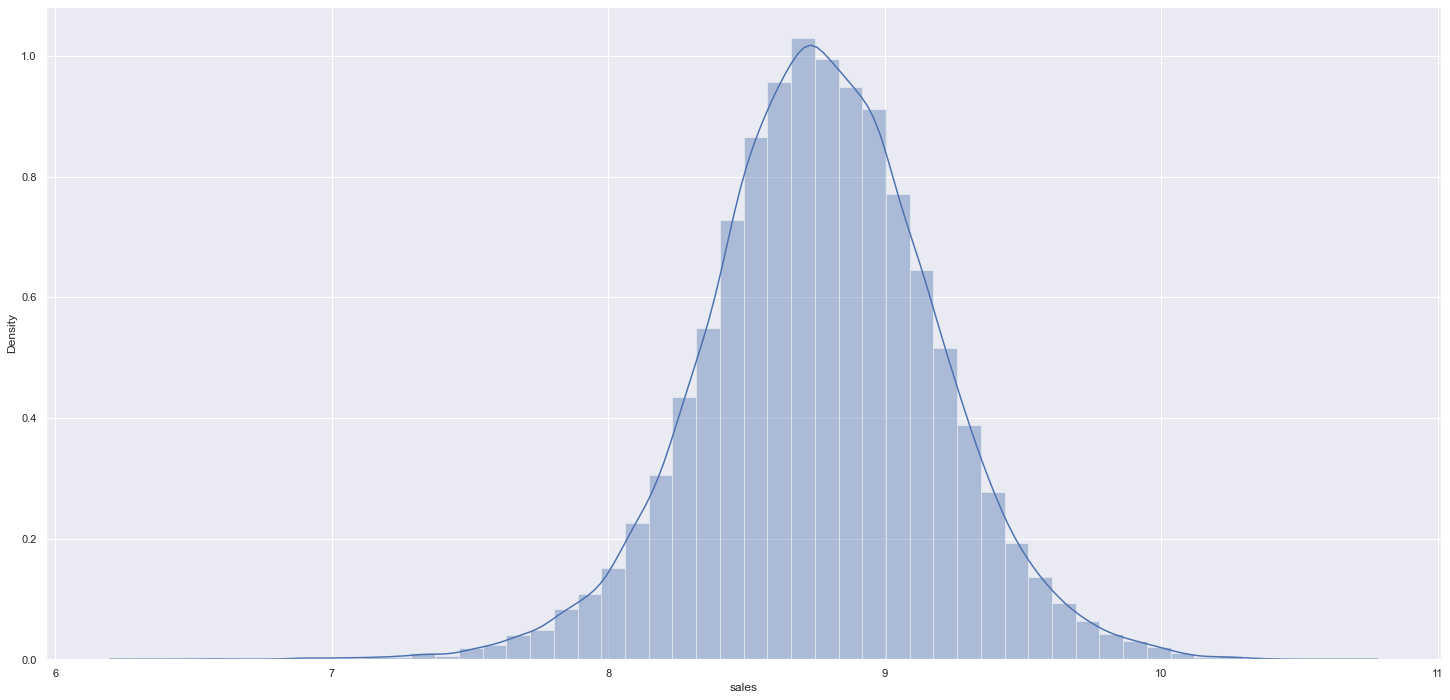

In [10]:
sns.distplot(y_test)

In [11]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [16]:
def ml_error(model_name,y,yhat):
    import numpy as np
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name':model_name,
                        'MAE':mae,
                        'MAPE':mape,
                        'RMSE':rmse},index=[0])

In [18]:
aux_1 = x_test.copy()
aux_1['sales'] = y_test.copy()

# prediction
aux_2 = aux_1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux_1 = pd.merge(aux_1,aux_2,how='left',on='store')
yhat_baseline = aux_1['predictions']

#performace
baseline_result = ml_error('Average Model', np.expm1(y_test),np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800167,0.206441,1835.141019


## Linear regression Model

In [20]:
from sklearn.linear_model import LinearRegression

In [23]:
#model
lr = LinearRegression().fit(x_train,y_train)


# prediction
yhat_lr = lr.predict(x_test)

lr_result = ml_error("Linear Regression",np.expm1(y_test),np.expm1(yhat_lr))

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.651729,0.292898,2671.341479


## Linear Regression Regularized Model - Lasso

In [24]:
from sklearn.linear_model import Lasso

In [33]:
#model
ls = Lasso(alpha=0.001).fit(x_train,y_train)


# prediction
yhat_ls = ls.predict(x_test)

ls_result = ml_error("Linear Regression Lasso",np.expm1(y_test),np.expm1(yhat_ls))

In [34]:
ls_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Lasso,1869.897925,0.292868,2677.289952


# Feature selection